# Inference Phase of SNN on Modulation Classification Datasets

The code is only for inference on M-QAM modulation dataset, the inference method is based on the rank order encoding. Winner neuron at the output layer is determined by the first neuron to spike


In [1]:
import torch 
import torch.nn
import matplotlib.pyplot as plt 
import pickle
import h5py
import time as tm 
#%matplotlib inline
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages, plot_weights
from bindsnet.learning import PostPre
from bindsnet.analysis.visualization import summary, plot_spike_trains_for_example, plot_voltage
from bindsnet import encoding
from tqdm import tqdm

In [2]:
#check cuda availibilty
device = 'cpu' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cpu


# 0. Define the helper's function


In [3]:
def encode_increase_sr_2(datum: torch.Tensor, time: int, dt: float = 1.0)-> torch.Tensor:
    '''
    input : rate, spike rate (number of spike per second)
    input : time, length of spike train
    return : tensor with dimension [nk,ni]
    '''
    assert (datum >= 0).all(), "Inputs must be non-negative"    
    datum[datum==1]=2 #minimum rate of 2
    # Get shape and size of data.
    shape, size = datum.shape, datum.numel()
    datum = datum.flatten()
    time = int(time / dt)

    spike_cr = torch.zeros(time+1,size).byte() #spike train
    dist_max = (time/(datum-1))
    
    for i,val in enumerate(dist_max):
        dist_incr = torch.arange(datum[i].item()) * (val/(datum[i]-1))        
        times = np.round(torch.arange(datum[i].item()) * dist_incr)
        spike_cr[times.long(),i]=1    
    
    return spike_cr[1:].view(time,*shape)


# 1. Build the SNNs model and load the trained weights


In [4]:
#load the weight
#output the file into a variable
filename = 'saved_weight_snn_4QAM_40HL_18dB_100prcnt'
infile = open(filename,'rb')
load_weight  = pickle.load(infile)

#define the number of neuron in each layer
nodes = [2,40,4]

Time = 100 #training and inference time duration for each example
tau_m = 100 #time constant of decaying spike
T_ref = 1 #refractory period of neuron
delta_v = [3,55]
v_rest = -65
V_th =[-62,-10] #voltage threshold of neuron
V_th1 = V_th[0]+torch.zeros(1,nodes[1]) #voltage threshold for hidden layer 
V_th2 = V_th[1]+torch.zeros(1,nodes[2]) #voltage threshold for hidden layer
k = 2 #weight initialization constant

#define the network object
network = Network()

#define the type of layer
source_layer = Input(n=nodes[0],traces=False)
hidden_layer = LIFNodes(n=nodes[1],trace=False,refrac=T_ref,thresh=V_th1,tc_decay=tau_m,sum_input=False,lbound=v_rest - delta_v[0])
target_layer = LIFNodes(n=nodes[2],traces=False,refrac=T_ref,thresh=V_th2,tc_decay=tau_m,sum_input=False,lbound=v_rest - delta_v[1])
#adding layer to the network
network.add_layer(
    layer = source_layer, name="A"
)
network.add_layer(
    layer = hidden_layer, name="B"
)
network.add_layer(
    layer = target_layer, name="C"
)

#define the connection for each layer
#create a connection between input and hidden layers
forward_connection1 = Connection(
    source = source_layer,
    target= hidden_layer,
    #load weight initialization according to Lee et.al     
    w = load_weight["hid"]
)
network.add_connection(
    connection=forward_connection1, source="A", target="B"
)
#create a connection between hidden layer and output layer
forward_connection2 = Connection(
    source = hidden_layer,
    target = target_layer,
    #load the weight initialization according to Lee et.al        
    w = load_weight["out"]
)
network.add_connection(
    connection=forward_connection2, source="B", target="C"
)

#create and add input and output layer monitor
source_monitor = Monitor(
    obj = source_layer,
    state_vars = ("s",), #record spikes and voltages
    time = Time , 
)
hidden_monitor = Monitor(
    obj = hidden_layer,
    state_vars=("s","v"),
    time = Time ,
)
target_monitor = Monitor(
    obj = target_layer,
    state_vars= ("s", "v"),
    time = Time ,
)
#add the monitor to the network
network.add_monitor(monitor=source_monitor, name="A")
network.add_monitor(monitor=hidden_monitor, name="B")
network.add_monitor(monitor=target_monitor, name="C")

#network.cuda(device)

# 2. Generate the Datasets 

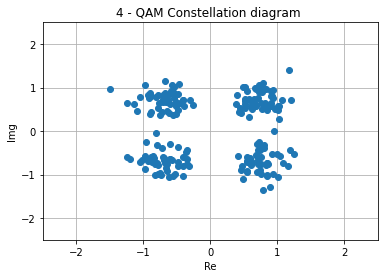

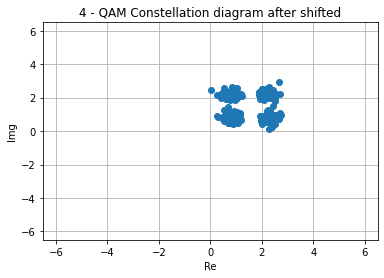

In [6]:
#generate 4 level quadrature amplitude modulation
M =  4
N_samples = 200

#QAM modulation format
qam = [ ( 2 * m - int(np.sqrt( M ) ) + 1 ) * 1  + 1j * ( 2 * n - int(np.sqrt( M ) ) + 1  ) for m in range( int(np.sqrt( M ) )) for n in range( int(np.sqrt(M) )) ]
qam /= np.linalg.norm( qam ) / np.sqrt( M )


#define the noise power
SNR_dB = 10 # the SNR Value in dB
sigma2_n = 1**2 * 10**( - SNR_dB / 10 ) # get the noise variance

c = np.zeros(N_samples) + 1j*np.zeros(N_samples)
#generate the signal and add the effect of the noise
s = np.random.randint(M, size= N_samples) #generate N number of symbols

for i,val in enumerate(s):#assign symbol to certain constellation signal
    c[i] = qam[val] #change this to choose between psk and qam modulation scheme

n = np.random.randn( N_samples ) + 1j * np.random.randn( N_samples ) #complex noise
z = c + np.sqrt( sigma2_n / 2)*n
#z = z + (1 + 1j)
#convert to torch tensor
s = torch.from_numpy(s)
z = torch.from_numpy(z)
#plot
plt.plot( np.real( z ), np.imag( z ), '.', markersize = 12  )
plt.xlim( (-2.5, 2.5) )
plt.ylim( (-2.5, 2.5) )
plt.title('%d - QAM Constellation diagram '%M)
plt.xlabel('Re')
plt.ylabel('Img')
plt.grid(True)  
plt.show()
#plot after the points are shifted to the 1st quadrant
plt.plot( np.real( z )+1.5, np.imag( z )+1.5, '.', markersize = 12  )
plt.xlim( (-6.5, 6.5) )
plt.ylim( (-6.5, 6.5) )
plt.title('%d - QAM Constellation diagram after shifted'%M)
plt.xlabel('Re')
plt.ylabel('Img')
plt.grid(True)  
plt.show()


## 2.1 Convert the datasets into spike train

elapsed time for one forward propagation 70.2219  ms


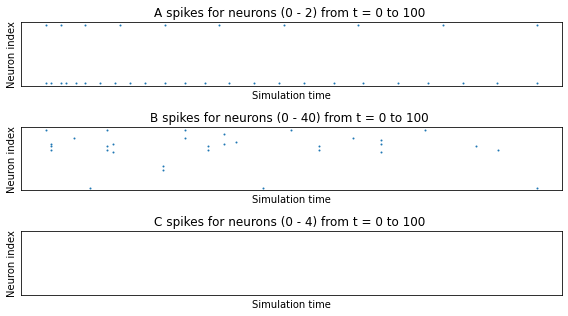

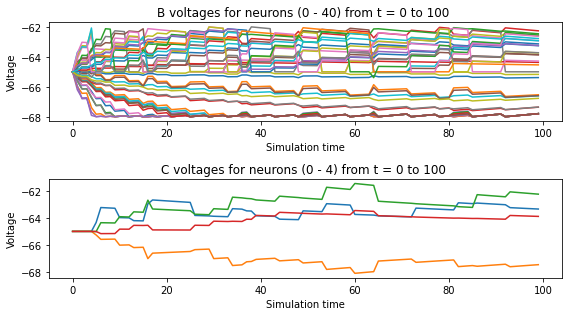

In [8]:
network.layers["C"].reset_state_variables() #reset neuron internal voltage
network.layers["B"].reset_state_variables() #reset neuron internal voltage   
#convert all the amplitude data into the spike rate
mod_type = "cplx"

max_rate = 25 #maximum rate in Hz # poisson 400
rate = torch.zeros(z.shape)
input_data = torch.zeros(N_samples*Time,nodes[0],device=device)


for i,val in enumerate(z):
    #print(i,val,y[i])
    if (nodes[0]==1): #check if the input is one
        rate = torch.tensor([val*max_rate]).squeeze()
        input_data[i*Time:(i*Time)+Time,0] = encoding.poisson(datum=rate.int(),time=Time) 
    if (mod_type=="cplx"):
        rate = torch.tensor([[(np.real(val)+1.5)*max_rate],[(np.imag(val)+1.5)*max_rate]]).squeeze()              
        #convert into poisson distributed spike train
        #input_data[i*Time:(i*Time)+Time,:] = encoding.poisson(datum=rate.int(),time=Time) 
        input_data[i*Time:(i*Time)+Time,:] = encode_increase_sr_2(datum=rate.int(),time=Time) 
    else:
        rate = torch.tensor([[val*max_rate],[(2*M-val)*max_rate]]).squeeze() #convert amplitude to spike rate
        #convert into poisson distributed spike train
        input_data[i*Time:(i*Time)+Time,:] = encoding.poisson(datum=rate.int(),time=Time) 

y = torch.nn.functional.one_hot(torch.tensor(s,device=device))  #convert label to one hot encoding

#feed the input spike train into the network
#run the network
j = np.random.choice(N_samples) #randomly choose the index of input data
j = 44

start_time = tm.time_ns()

inputs = {'A':input_data[j*Time:(j*Time)+Time,:]}
network.run(inputs=inputs , time=Time)
#record spike activity and neuron voltage
end_time = tm.time_ns()
spikes = {
    "A": network.monitors['A'].get('s'), 
    "B": network.monitors['B'].get("s"),
    "C": network.monitors['C'].get("s"),
}
voltages = {"B": network.monitors['B'].get("v"),
            "C": network.monitors['C'].get("v")}

print("elapsed time for one forward propagation %1.4f  ms"%((end_time-start_time)/1e6))

#plot the result
plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.show()
#reset the voltage neuron
network.layers["C"].reset_state_variables()
network.layers["B"].reset_state_variables()    

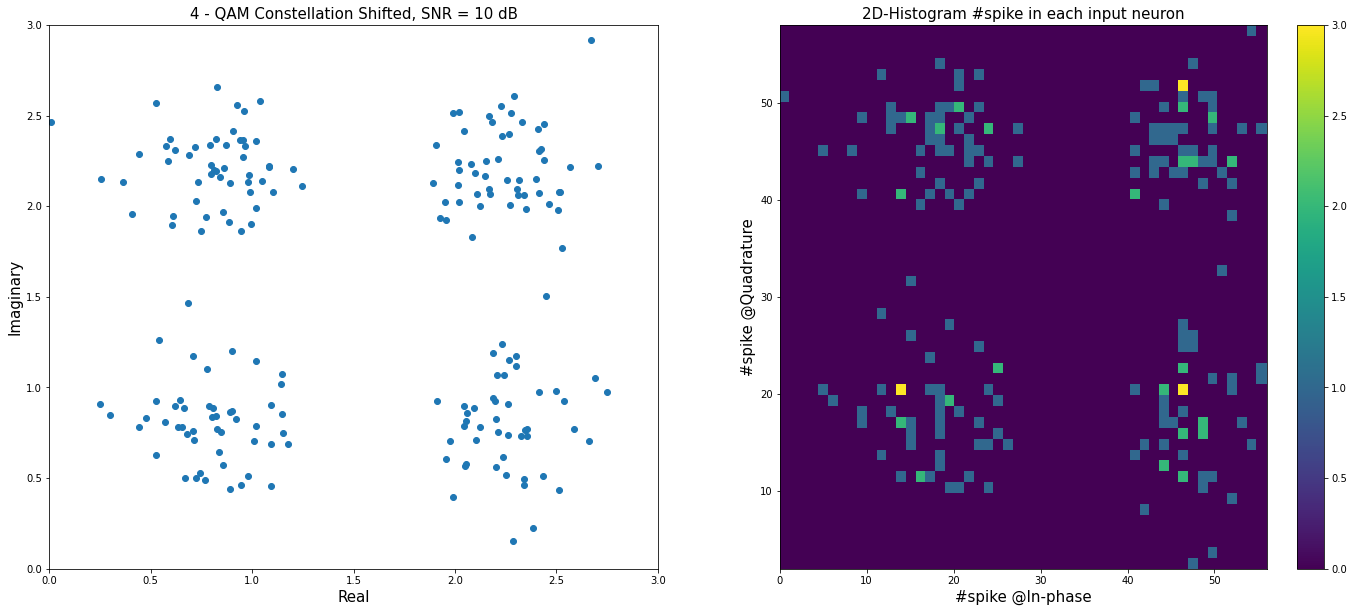

In [10]:
#print the number of input spike at each input neuron
num_spike_I = torch.zeros(N_samples)
num_spike_Q = torch.zeros(N_samples)
for i in range(N_samples):
    sample_data = input_data[i*Time:(i*Time)+Time,:]
    if (nodes[0]==1):
        print('sample %d, sent symbol %d, total spikes : %d '%(i,s[i],sum(sample_data[:,0]).item()))
    else:        
        num_spike_I[i] = sum(sample_data[:,0]).item()
        num_spike_Q[i] = sum(sample_data[:,1]).item()
        #print('sample %d, sent symbol %d,  total spikes : %d ; %d'%(i,s[i],num_spike_I[i],num_spike_Q[i]))
    #print(sum(sample_data[:,0]).item())
    #print(sum(sample_data[:,1]).item())

#plot the 2D histogram
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=[24,10])
hist_spike = ax2.hist2d(num_spike_I.numpy(),num_spike_Q.numpy(),bins=50)
ax2.set_title("2D-Histogram #spike in each input neuron",fontsize=15)
ax2.set_xlabel("#spike @In-phase",fontsize=15)
ax2.set_ylabel("#spike @Quadrature",fontsize=15)
plt.colorbar(hist_spike[3],)

#plot after the points are shifted to the 1st quadrant
ax1.plot( np.real( z )+1.5, np.imag( z )+1.5, '.', markersize = 12  )
ax1.set_xlim( (0, 3) )
ax1.set_ylim( (0, 3) )
ax1.set_title('%d - QAM Constellation Shifted, SNR = %d dB'%(M,SNR_dB),fontsize=15)
ax1.set_xlabel('Real',fontsize=15)
ax1.set_ylabel('Imaginary',fontsize=15)
#ax2.set_grid(True)  
plt.show()

# 3. Run the Inference

## 3.1 Run Classification by determining the membrane voltage of last layer


In [11]:
#set the membrane voltage threshold 
network.layers["C"].thresh = -10 * torch.ones(nodes[2])
network.layers["C"].reset_state_variables()
network.layers["B"].reset_state_variables()

#run the final prediction
y_pred_run = torch.zeros(N_samples)
for j in range(N_samples):
    inputs = {"A":input_data[j*Time:(j*Time)+Time,:]}
    network.run(inputs=inputs,time=Time)
    #fetch the spikes and voltage value
    spikes = {
        "A": network.monitors['A'].get('s'), 
        "B": network.monitors['B'].get("s"),
        "C": network.monitors['C'].get("s"),
    }
    voltages = {#"B": network.monitors['B'].get("v"),
                "C": network.monitors['C'].get("v")}    

    #check membrane voltage at the last layer    
    a_out = (network.layers['C'].v)    
    #print(a_out)
    y_pred_run[j] = torch.argmax(a_out)
    #reset the membrane voltage
    network.layers["C"].reset_state_variables()
    network.layers["B"].reset_state_variables()

#print("Output final layer ",y_pred_run) 
#print("target vector %s"%s)
#calculate accuracy
accr = (torch.sum(y_pred_run==s)*100/N_samples)
print("Accuracy : "+str(accr.item())+" % ")

Accuracy : 94.0 % 


## 3.2 Run Classification by determining which neuron spike first at the last layer

tensor([-64.0000, -63.5000, -63.0000, -62.5000, -62.0000, -61.5000, -61.0000,
        -60.5000, -60.0000])
Threshold -64.0Accuracy : 24.5 % 
Threshold -63.5Accuracy : 32.0 % 
Threshold -63.0Accuracy : 60.0 % 
Threshold -62.5Accuracy : 96.0 % 
Threshold -62.0Accuracy : 97.0 % 
Threshold -61.5Accuracy : 88.0 % 
Threshold -61.0Accuracy : 73.0 % 
Threshold -60.5Accuracy : 60.0 % 
Threshold -60.0Accuracy : 53.0 % 


Text(0, 0.5, 'Accuracy (%)')

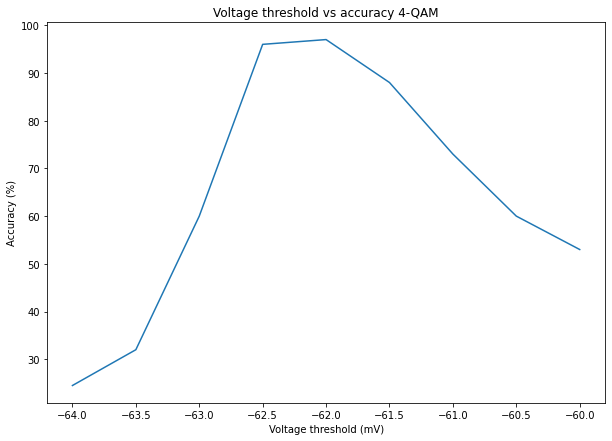

In [12]:
#try for every voltage threshold
delta_v = torch.linspace(v_rest+1,-60,9)
accuracy_vs = torch.zeros(delta_v.shape)  #accuracy by determining first neuron to spike
#accuracy_vs_2 =torch.zeros(delta_v.shape) #accuracy by calculating number of spike
print(delta_v)

for i,val in enumerate(delta_v):
    #set the voltage threshold
    network.layers["C"].thresh = val * torch.ones(nodes[2])
    #reset state variables 
    network.layers["C"].reset_state_variables()
    network.layers["B"].reset_state_variables()
    #loop every examples
    y_pred_run = torch.zeros(N_samples)
    for j in range(N_samples):
    
        #fetch the input data
        inputs = {"A":input_data[j*Time:(j*Time)+Time,:]} 
        #run the forward propagation with input data
        network.run(inputs=inputs,time=Time)  
        spikes = {            
            "C": network.monitors['C'].get("s"),
        }
        #fetch the spike signal at the output layer
        a_out = torch.sum(network.monitors['C'].get("s").squeeze(),dim=0)
        
        #determine the coresponding class
        #y_pred_run[j] = torch.argmax(a_out,dim=0) # determine the class by observing which neuron to generate more spike
        #check if the output spike have the same number of spike        
        if(sum(a_out)==0):
            y_pred_run[j] = torch.argmax(a_out,dim=0)
        else:    
            y_pred_run[j] = (spikes["C"].squeeze().int()==1).nonzero()[0,1] #determine the class by observing which neuron to spike first
        
        #reset state variables 
        network.layers["C"].reset_state_variables()
        network.layers["B"].reset_state_variables()
    
    #calculate accuracy    
    accuracy_vs[i] = (torch.sum(y_pred_run==s)*100/N_samples)
    print("Threshold "+str(delta_v[i].item())+"Accuracy : "+str(accuracy_vs[i].item())+" % ")


#plot inference accuracy vs. voltage threshold
plt.figure(figsize=[10,7])
plt.plot(delta_v,accuracy_vs)
plt.title("Voltage threshold vs accuracy 4-QAM")
plt.xlabel("Voltage threshold (mV)")
plt.ylabel("Accuracy (%)")

## 3.3 Run Classification by using Maximum Likelihood detector


Text(0, 0.5, 'Accuracy (%)')

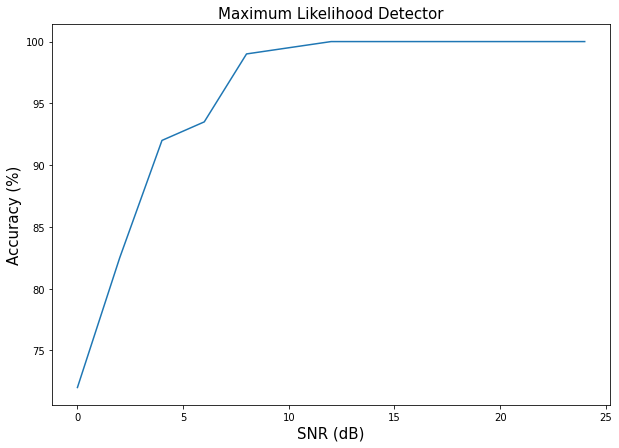

In [13]:
#run for different SNR value
SNR_val = [0,2,4,6,8,10,12,14,16,18,20,22,24]
accuracy_ml = torch.zeros(len(SNR_val))

for i,SNR in enumerate(SNR_val):
    sigma2_n = 1**2 * 10**( - SNR / 10 ) # get the noise variance
    n = np.random.randn( N_samples ) + 1j * np.random.randn( N_samples ) #complex noise
    z = c + np.sqrt( sigma2_n / 2)*n #signal plus noise
    #z = z + (1 + 1j)
    #convert to torch tensor
    z = torch.from_numpy(z)
    #maximum likelihood detection
    z = z.view(N_samples,1)
    s_hat = torch.argmin(torch.abs(z - qam),dim=1) #take minimum argument of euclidean distance
    accuracy_ml[i] = sum(s_hat==s)*100/N_samples #calculate the accuracy

#plot the accuracy vs SNR
plt.figure(figsize=[10,7])
plt.plot(SNR_val,accuracy_ml)
plt.title("Maximum Likelihood Detector",fontsize=15)
plt.xlabel("SNR (dB)",fontsize=15)
plt.ylabel("Accuracy (%)",fontsize=15)

## 3.4 Run Classification in SNN by using rank order for different SNR value

In [15]:
accuracy_snn_ro = torch.zeros(len(SNR_val))
input_data = torch.zeros(N_samples*Time,nodes[0],device=device)

#set the voltage threshold
network.layers["C"].thresh = delta_v[torch.argmax(accuracy_vs)] * torch.ones(nodes[2])#delta_v[torch.argmax(accuracy_vs)] * torch.ones(nodes[2])
#reset state variables 
network.layers["C"].reset_state_variables()
network.layers["B"].reset_state_variables()

for i,SNR in enumerate(SNR_val):
    sigma2_n = 1**2 * 10**( - SNR / 10 ) # get the noise variance
    n = np.random.randn( N_samples ) + 1j * np.random.randn( N_samples ) #complex noise
    z = c + np.sqrt( sigma2_n / 2)*n #signal plus noise
    #z = z + (1 + 1j)
    #convert to torch tensor
    z = torch.from_numpy(z)
    #convert into spike train

    for j,val in enumerate(z):
        rate = torch.tensor([[(np.real(val)+1.5)*max_rate],[(np.imag(val)+1.5)*max_rate]]).squeeze()    
        rate = torch.absolute(rate)      #make absolute    
        #convert into linearly decreasing rate spike train        
        input_data[j*Time:(j*Time)+Time,:] = encode_increase_sr_2(datum=rate.int(),time=Time) 
        
        #feed the spike train into the network
        #fetch the input data
        inputs = {"A":input_data[j*Time:(j*Time)+Time,:]} 
        #run the forward propagation with input data
        network.run(inputs=inputs,time=Time)  
        spikes = {            
            "C": network.monitors['C'].get("s"),
        }
        #fetch the spike signal at the output layer
        a_out = torch.sum(network.monitors['C'].get("s").squeeze(),dim=0)
        
        #determine the coresponding class
        #y_pred_run[j] = torch.argmax(a_out,dim=0) # determine the class by observing which neuron to generate more spike
        #check if the output spike have the same number of spike        
        if(sum(a_out)==0):
            y_pred_run[j] = torch.argmax(a_out,dim=0)
        else:    
            y_pred_run[j] = (spikes["C"].squeeze().int()==1).nonzero()[0,1] #determine the class by observing which neuron to spike first
        
        #reset state variables 
        network.layers["C"].reset_state_variables()
        network.layers["B"].reset_state_variables()
    
    #calculate accuracy    
    accuracy_snn_ro[i] = (torch.sum(y_pred_run==s)*100/N_samples)
    print("SNR %d dB, Accuracy %.2f percent "%(SNR,accuracy_snn_ro[i]))
    #print("Threshold "+str(delta_v[i].item())+"Accuracy : "+str(accuracy_vs[i].item())+" % ")


SNR 0 dB, Accuracy 63.50 percent 
SNR 2 dB, Accuracy 67.00 percent 
SNR 4 dB, Accuracy 79.50 percent 
SNR 6 dB, Accuracy 86.50 percent 
SNR 8 dB, Accuracy 91.50 percent 
SNR 10 dB, Accuracy 96.50 percent 
SNR 12 dB, Accuracy 97.50 percent 
SNR 14 dB, Accuracy 99.50 percent 
SNR 16 dB, Accuracy 100.00 percent 
SNR 18 dB, Accuracy 100.00 percent 
SNR 20 dB, Accuracy 100.00 percent 
SNR 22 dB, Accuracy 100.00 percent 
SNR 24 dB, Accuracy 100.00 percent 


Text(0, 0.5, 'Accuracy (%)')

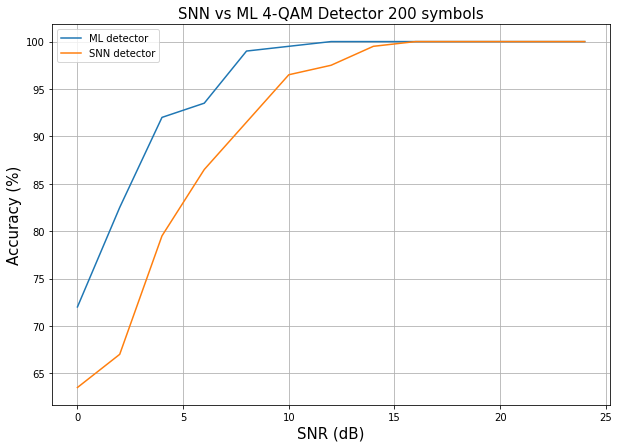

In [17]:
#plot the accuracy vs SNR
plt.figure(figsize=[10,7])
plt.plot(SNR_val,accuracy_ml,label='ML detector')
plt.plot(SNR_val,accuracy_snn_ro,label='SNN detector')
plt.legend()
plt.grid(True,which='both')
plt.title("SNN vs ML 4-QAM Detector %d symbols"%N_samples,fontsize=15)
plt.xlabel("SNR (dB)",fontsize=15)
plt.ylabel("Accuracy (%)",fontsize=15)